<a href="https://colab.research.google.com/github/TailUFPB/fundos-imobiliarios/blob/main/Rankeamento_Modelo_FIIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rankeamento de fundos imobiliários e modelo de classificação


In [ ]:
#Imports
import pandas as pd
import numpy as np


!pip install Jinja2==3.1.2
#!pip install pycaret
!pip install pycaret==2.3.10 markupsafe==2.0.1 pyyaml==5.4.1 -qq

from pycaret.classification import *

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import sklearn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


#RESTARTA O KERNEL DEPOIS

  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Rankeamento dos fundos:

O objetivo da primeira parte desse notebook é rankear os fundos imobiliários no Brasil, a fim de descobrir quais são os melhores, segundo as variáveis analisadas.

Para rankear os FIIs, a fim de descobrir quais melhores segundo as regras adotadas no presente trabalho, será utilizada a estratégia de atribuir uma nota para cada um deles, que levará em consideração os atributos atuais de cada um.




---


Primeiramente, vamos pegar o CSV com atributos atuais dos fundos, que ficará na variável df:

In [ ]:
#Recebendo o CSV dos fundos
df = ""
url = 'https://raw.githubusercontent.com/lazs/tcc_pucmg/main/FIIs-2022.csv'
data = pd.read_csv(url, encoding = "ISO-8859-1", decimal = ",", thousands="." , on_bad_lines="skip", sep=";")
df = pd.DataFrame(data)

In [ ]:
df.head()

,Código do fundo,Setor,Preço Atual,Liquidez Diária,Dividendo,DividendYield,DY (3M)Acumulado,DY (6M)Acumulado,DY (12M)Acumulado,DY (3M)Média,...,PatrimônioLíq.,VPA,P/VPA,DYPatrimonial,Rentab. Patr.no Período,Rentab. Patr.Acumulada,VacânciaFísica,VacânciaFinanceira,QuantidadeAtivos,VariaçãoPatrimonial
0,AFHI11,Títulos e Val. Mob.,98.55,9820,1.35,1.31,3.85,7.64,0.00,1.28,...,1.738249e+08,97.24,1.01,1.39,1.83,3.20,0.0,0.0,0,0.44
1,AFOF11,Títulos e Val. Mob.,89.22,1511,1.01,1.07,3.21,6.26,0.00,1.07,...,7.072136e+07,102.32,0.87,0.98,2.25,5.57,0.0,0.0,0,1.26
2,ARRI11,Títulos e Val. Mob.,95.22,1294,1.28,1.30,3.94,8.59,15.68,1.31,...,9.866189e+07,94.11,1.01,1.42,3.58,6.18,0.0,0.0,0,2.12
3,BARI11,Títulos e Val. Mob.,100.00,6416,1.30,1.27,3.41,6.94,13.27,1.14,...,4.726223e+08,101.99,0.98,1.08,1.45,3.74,0.0,0.0,0,0.37
4,BBFO11,Títulos e Val. Mob.,71.39,3143,0.77,1.05,3.03,5.96,10.31,1.01,...,3.431596e+08,85.71,0.83,0.90,1.18,2.46,0.0,0.0,0,0.28


In [ ]:
pd.set_option("display.max_rows", None)

Hipóteses:

- Retirar do dataframe todos fundos com:

1- Valores NEGATIVOS de variáveis, tal qual rentabilidades negativas, que poderiam indicar que o fundo tem se depreciado ao longo do tempo.

2- Fundo que tenham negociação (liquidez diária) menor que 1000, para garantir que o fundo não seja manipulado por alguns cotistas e para garantir que o fundo tenha representatividade na bolsa de valores.


In [ ]:
#rever isso.... Dando problema.

#df = df[df.select_dtypes(include=['number']).ge(0).all(1)]

#num = df._get_numeric_data()
#num[num < 0] = 0

#df = df[df['Liquidez Diária'] < 1000]




---


Agora, vamos definir as funções que iremos utilizar para obter a nota de cada fundo:

Na função *NotaInicial*, será alguns atributos do fundo para dar uma nota inicial a ele, multiplicando o valor por um peso dado a cada atributo baseado na sua importância para a avaliação do fundo, ou seja, se o peso do campo for positivo, quanto maior for o valor do atributo, melhor nota obterá.
O somatório dos pesos foi definido como 1, que seria 100% da nota.

In [ ]:
#Dando notas para colunas que não tem delimitador definido (Quanto mais alto ou mais baixo, melhor)
def NotaInicial(df):
  pesos = {'DividendYield': 0.02,'DY (3M)Média': 0.08, 'DY (6M)Média': 0.15, 'DY (12M)Média': 0.25, 'P/VPA': 0.5 } 
  colunas = [ 'DividendYield', 'DY (3M)Média','DY (6M)Média','DY (12M)Média', 'P/VPA' ] 
  i = 0
  notas = []

  while i < df.shape[0]:

    nota_row = 0
    for j in colunas:
      if j in df.columns:
        nota_row += pesos[j] * (df.loc[i, j])#- df[j].mean())
        #print(str(df.iloc[i,0])+"-------"+str(nota_row))#+"----"+str(df.iloc[0,j])


    notas.append(nota_row)

    i += 1



  df['Notas'] = notas

  

  return df

Com as funções definidas, podemos começar nossa análise aplicando as três funções iniciais ao nosso dataset:

In [ ]:
#MELHORIAS: 
#@todo: definir PREMISSAS 
#de numero de negociações minimas
#tirar monoativos
#patrimonio em $$ minimo


#@TODO: definir a MEDIA para cada setor 
#@TODO: definir a Mediana para cada setor 

#todo 
#criar 3 ranges de VPA: alto, normal, baixo:
# alto > 1.2
# normal > 0.8 < 1.2
# baixo <=0.8

#o baixo PODE SER UMA OPORTUNIDADE


#Se usar o PRECO DO ATIVO.. pode se ter um problema na questão da BASE 10 OU BASE 100

pesos = {'DividendYield': 0.02,'DY (3M)Média': 0.08, 'DY (6M)Média': 0.15, 'DY (12M)Média': 0.25, 'P/VPA': 0.5 } 
colunas = [ 'DividendYield', 'DY (3M)Média','DY (6M)Média','DY (12M)Média', 'P/VPA' ] 
i = 0
notas = []

while i < df.shape[0]:

  nota_row = 0
  for j in colunas:
    if j in df.columns:
      nota_row += pesos[j] * (df.loc[i, j])#- df[j].mean())
      #print(str(df.iloc[i,0])+"-------"+str(nota_row))#+"----"+str(df.iloc[0,j])


  notas.append(nota_row)

  i += 1



df['Notas'] = notas





In [ ]:
df = df[['Código do fundo' ,'DividendYield', 'DY (3M)Média','DY (6M)Média','DY (12M)Média', 'P/VPA' , 'Notas']]
df.head()

,Código do fundo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,P/VPA,Notas
0,AFHI11,1.31,1.28,1.27,0.00,1.01,0.8241
1,AFOF11,1.07,1.07,1.04,0.00,0.87,0.6980
2,ARRI11,1.30,1.31,1.43,1.31,1.01,1.1778
3,BARI11,1.27,1.14,1.16,1.11,0.98,1.0581
4,BBFO11,1.05,1.01,0.99,0.86,0.83,0.8803


Avaliar como está a distribuição das Notas e corrigir possíveis distorções.

Este é um dos métodos amplamente utilizados para a normalização. O resultado da normalização subtrai o valor mínimo de um quadro de dados e divide-o pela diferença entre o valor mais alto e mais baixo da coluna correspondente.

In [ ]:

def minmax_norm(df_input):
    return (df - df.min()) / ( df.max() - df.min())


def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)

df_minmax_norm = mean_norm(df.iloc[:,1:])
print(df_minmax_norm)

     DividendYield  DY (3M)Média  DY (6M)Média  DY (12M)Média      P/VPA  \
0         1.087857      1.167018      1.295301      -1.447802   0.435713   
1         0.517584      0.650166      0.746251      -1.447802   0.096689   
2         1.064095      1.240854      1.677248       1.735531   0.435713   
3         0.992811      0.822450      1.032712       1.249526   0.363065   
4         0.470062      0.502495      0.626892       0.642020  -0.000175   
5        -0.551677     -1.983315     -1.736409      -1.447802   0.096689   
6        -2.024880     -1.983315     -1.736409      -1.447802  -2.010107   
7        -0.100211     -0.014357      0.101714       0.277516  -0.000175   
8        -0.052688      0.034867      0.149458       0.374717  -0.121256   
9         0.778959      0.871674      1.032712       1.273826   0.435713   
10       -2.024880     -1.983315     -1.736409      -1.447802   0.605225   
11        0.636391      0.157927      0.006227      -0.038387   0.338849   
12        0.

Notas pré normalização

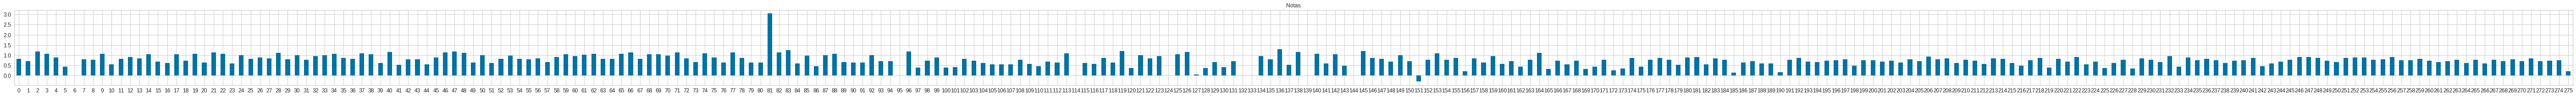

In [ ]:
#%matplotlib inline
plt.rcParams["figure.figsize"] = (100,3)

df['Notas'].plot.bar(rot=0, title='Notas', fontsize=12)


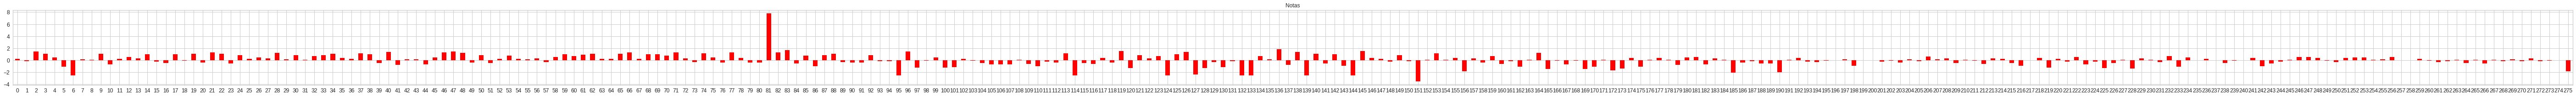

In [ ]:
df_minmax_norm['Notas'].plot.bar(rot=0, title='Notas', fontsize=12, color='red')

E ficamos com o seguinte rankeamento dos fundos:

In [ ]:
df_sort = df.sort_values('Notas', ascending=False)
df_sort.reset_index(drop=True, inplace=True)
#df_sort = df_sort[['Código do fundo', 'Setor', 'Preço Atual', 'Notas']]
df_sort = df_sort[['Código do fundo','Notas']]

In [ ]:
df_sort

,Código do fundo,Notas
0,SRVD11,3.0452
1,URPR11,1.3007
2,VGHF11,1.2416
3,ARCT11,1.1989
4,KINP11,1.1932
5,ARRI11,1.1778
6,KNIP11,1.1717
7,CACR11,1.1716
8,JPPA11,1.1653
9,QAMI11,1.1559


## Modelo de classificação de fundos

Agora, podemos também fazer um modelo de Machine Learning que, com os dados de um fundo em mãos, possa classificá-lo em: bom, médio ou ruim.

Para fazer isso, primeiro vamos utilizar os datasets que já temos para treinar o modelo:

In [ ]:
dfs_modelo = []
url = 'https://raw.githubusercontent.com/lazs/tcc_pucmg/main/FIIs-2022.csv'
data = pd.read_csv(url, encoding = "ISO-8859-1", decimal = ",", thousands="." , on_bad_lines="skip", sep=";")

#data.drop(['Setor','Liquidez Diária','Variação Preço','PatrimônioLíq.','DYPatrimonial',	'Rentab. Patr.no Período',	'Rentab. Patr.Acumulada',	'VacânciaFísica',	'VacânciaFinanceira',	'QuantidadeAtivos',	'VariaçãoPatrimonial'], axis='columns', inplace=True)
data =data[['Código do fundo', 'DividendYield', 'DY (3M)Média','DY (6M)Média','DY (12M)Média', 'P/VPA' ]]


dfs_modelo.append(pd.DataFrame(data))


In [ ]:
#dfs_modelo[0].drop(['Setor', 'Preço Atual', 'Dividendo', 'DY Ano'], axis='columns', inplace=True)

# dfs_modelo[0].drop(['Liquidez Diária','Variação Preço','PatrimônioLíq.','DYPatrimonial',	'Rentab. Patr.no Período',	'Rentab. Patr.Acumulada',	'VacânciaFísica',	'VacânciaFinanceira',	'QuantidadeAtivos',	'VariaçãoPatrimonial'], axis='columns', inplace=True)


dfs_modelo[0]

,Código do fundo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,P/VPA
0,AFHI11,1.31,1.28,1.27,0.00,1.01
1,AFOF11,1.07,1.07,1.04,0.00,0.87
2,ARRI11,1.30,1.31,1.43,1.31,1.01
3,BARI11,1.27,1.14,1.16,1.11,0.98
4,BBFO11,1.05,1.01,0.99,0.86,0.83
5,BBGO11,0.62,0.00,0.00,0.00,0.87
6,BBIM11,0.00,0.00,0.00,0.00,0.00
7,BCFF11,0.81,0.80,0.77,0.71,0.83
8,BCIA11,0.83,0.82,0.79,0.75,0.78
9,BCRI11,1.18,1.16,1.16,1.12,1.01


Vamos dar uma nota para todos os fundos desse nosso dataset, utilizando as funções do começo do notebook:

In [ ]:
for i in range(len(dfs_modelo)):
  dfs_modelo[i] = NotaInicial(dfs_modelo[i])
  #dfs_modelo[i] = PVPA(dfs_modelo[i])
  #dfs_modelo[i] = DividendAnalysis(dfs_modelo[i])

dfs_modelo = pd.concat(dfs_modelo)

dfs_modelo = dfs_modelo.sort_values('Notas', ascending=False)
dfs_modelo.reset_index(drop=True, inplace=True)

Levando em consideração a nota obtida de cada modelo, podemos separá-los nas 3 categorias em que queremos classificar:

In [ ]:
dfs_modelo['Label'] = ''
for index, row in dfs_modelo.iterrows():
  if dfs_modelo.loc[index, 'Notas'] <= 0:
    dfs_modelo.loc[index,'Label'] = 'Ruim'
  elif dfs_modelo.loc[index, 'Notas'] <= 0.85:
    dfs_modelo.loc[index,'Label'] = 'Médio'
  else:
    dfs_modelo.loc[index,'Label'] = 'Bom'

dfs_modelo.drop(['Notas'], axis='columns', inplace=True)

In [ ]:
#dfs_modelo

Agora, podemos utilizar a biblioteca Pycaret para aplicar vários modelos de ML nos dados e descobrir qual o que melhor consegue 
classificá-los:

In [ ]:
#dfc = dfs_modelo.loc[:,['Preço Atual', 'Dividendo', 'DividendYield','DY (3M)Acumulado', 'DY (6M)Acumulado', 'DY (12M)Acumulado','DY (3M)Média', 'DY (6M)Média', 'DY (12M)Média', 'DY Ano', 'VPA', 'P/VPA', 'Label']]

In [ ]:
dfs_modelo.columns

Index(['Código do fundo', 'DividendYield', 'DY (3M)Média', 'DY (6M)Média',
       'DY (12M)Média', 'P/VPA', 'Label'],
      dtype='object')

In [ ]:
#dfs_modelo.drop(['DY (3M)Acumulado', 'DY (6M)Acumulado', 'DY (12M)Acumulado',
#       'DY (6M)Média',  'DY Ano',
#       'Rentab.Período', 'Rentab.Acumulada', 'VPA'], axis='columns', inplace=True)


In [ ]:
dfs_modelo

,Código do fundo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,P/VPA,Label
0,SRVD11,1.01,0.00,0.00,0.00,6.05,Bom
1,URPR11,1.72,1.51,1.52,1.53,1.07,Bom
2,VGHF11,1.28,1.40,1.51,1.39,1.06,Bom
3,ARCT11,1.54,1.47,1.52,1.17,1.06,Bom
4,KINP11,2.90,2.44,0.00,0.00,1.88,Bom
5,ARRI11,1.30,1.31,1.43,1.31,1.01,Bom
6,KNIP11,1.66,1.35,1.37,1.24,1.03,Bom
7,CACR11,1.39,1.36,1.40,1.26,1.02,Bom
8,JPPA11,1.74,1.60,1.45,1.24,0.95,Bom
9,QAMI11,1.29,1.22,1.35,1.24,1.04,Bom


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019
ridge,Ridge Classifier,0.8705,0.0000,0.6996,0.8437,0.8582,0.7141,0.7330,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019
ridge,Ridge Classifier,0.8705,0.0000,0.6996,0.8437,0.8582,0.7141,0.7330,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019
ada,Ada Boost Classifier,0.8758,0.6721,0.9214,0.8710,0.8816,0.7356,0.7524,0.693
ridge,Ridge Classifier,0.8705,0.0000,0.6996,0.8437,0.8582,0.7141,0.7330,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
gbc,Gradient Boosting Classifier,0.9171,0.6825,0.9377,0.9258,0.9195,0.8301,0.8407,0.312
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019
ada,Ada Boost Classifier,0.8758,0.6721,0.9214,0.8710,0.8816,0.7356,0.7524,0.693
ridge,Ridge Classifier,0.8705,0.0000,0.6996,0.8437,0.8582,0.7141,0.7330,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
gbc,Gradient Boosting Classifier,0.9171,0.6825,0.9377,0.9258,0.9195,0.8301,0.8407,0.312
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
lda,Linear Discriminant Analysis,0.9018,0.6712,0.9357,0.9106,0.9070,0.8028,0.8108,0.014
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019
ada,Ada Boost Classifier,0.8758,0.6721,0.9214,0.8710,0.8816,0.7356,0.7524,0.693
ridge,Ridge Classifier,0.8705,0.0000,0.6996,0.8437,0.8582,0.7141,0.7330,0.025


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
gbc,Gradient Boosting Classifier,0.9171,0.6825,0.9377,0.9258,0.9195,0.8301,0.8407,0.312
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
et,Extra Trees Classifier,0.9118,0.6871,0.9286,0.9263,0.9165,0.8229,0.8329,0.460
lda,Linear Discriminant Analysis,0.9018,0.6712,0.9357,0.9106,0.9070,0.8028,0.8108,0.014
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019
ada,Ada Boost Classifier,0.8758,0.6721,0.9214,0.8710,0.8816,0.7356,0.7524,0.693


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9224,0.6724,0.9313,0.9365,0.9233,0.8415,0.8513,0.080
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
gbc,Gradient Boosting Classifier,0.9171,0.6825,0.9377,0.9258,0.9195,0.8301,0.8407,0.312
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
et,Extra Trees Classifier,0.9118,0.6871,0.9286,0.9263,0.9165,0.8229,0.8329,0.460
lda,Linear Discriminant Analysis,0.9018,0.6712,0.9357,0.9106,0.9070,0.8028,0.8108,0.014
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9224,0.6724,0.9313,0.9365,0.9233,0.8415,0.8513,0.080
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
gbc,Gradient Boosting Classifier,0.9171,0.6825,0.9377,0.9258,0.9195,0.8301,0.8407,0.312
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
et,Extra Trees Classifier,0.9118,0.6871,0.9286,0.9263,0.9165,0.8229,0.8329,0.460
lda,Linear Discriminant Analysis,0.9018,0.6712,0.9357,0.9106,0.9070,0.8028,0.8108,0.014
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9224,0.6724,0.9313,0.9365,0.9233,0.8415,0.8513,0.080
svm,SVM - Linear Kernel,0.9171,0.0000,0.7405,0.8828,0.9051,0.8168,0.8342,0.079
gbc,Gradient Boosting Classifier,0.9171,0.6825,0.9377,0.9258,0.9195,0.8301,0.8407,0.312
knn,K Neighbors Classifier,0.9118,0.6741,0.9369,0.9194,0.9159,0.8214,0.8310,0.134
et,Extra Trees Classifier,0.9118,0.6871,0.9286,0.9263,0.9165,0.8229,0.8329,0.460
lda,Linear Discriminant Analysis,0.9018,0.6712,0.9357,0.9106,0.9070,0.8028,0.8108,0.014
rf,Random Forest Classifier,0.8966,0.6813,0.9246,0.8967,0.8978,0.7864,0.7979,0.641
dt,Decision Tree Classifier,0.8913,0.6091,0.9143,0.9020,0.8942,0.7755,0.7876,0.022
lr,Logistic Regression,0.8811,0.6769,0.7087,0.8519,0.8665,0.7327,0.7557,0.449
nb,Naive Bayes,0.8805,0.6578,0.9198,0.8755,0.8866,0.7430,0.7552,0.019


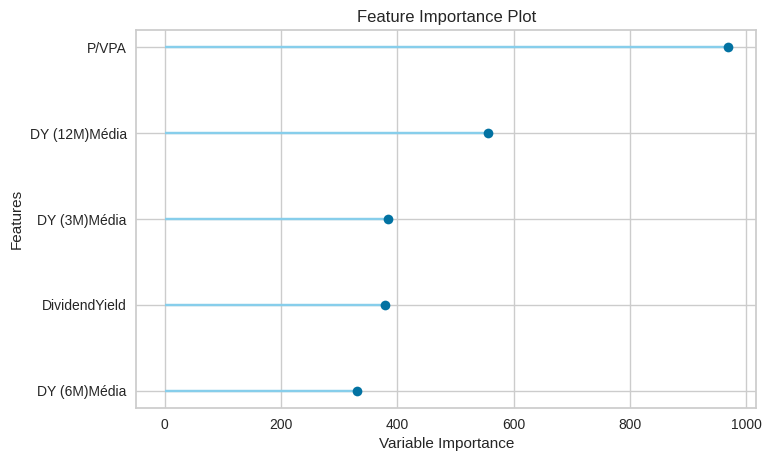

In [ ]:
#grid = setup(data=dfs_modelo.iloc[:,2:], target='Label', html=False, silent=True, verbose=False)
#grid = setup(data=dfs_modelo.loc[:,['Preço Atual', 'Dividendo', 'DividendYield','DY (3M)Acumulado', 'DY (6M)Acumulado', 'DY (12M)Acumulado','DY (3M)Média', 'DY (6M)Média', 'DY (12M)Média', 'DY Ano','Rentab.Período', 'Rentab.Acumulada', 'VPA', 'P/VPA', 'Label']], target='Label', html=False, silent=True, verbose=False)

grid = setup(data=dfs_modelo, target='Label', html=False, silent=True, verbose=False, ignore_features = [ 'Código do fundo' ])#,'DY (6M)Acumulado', 	'DY (12M)Acumulado', 'DY (3M)Média', 	'DY (6M)Média', 	'DY (12M)Média', 	'DY Ano' 	,'Rentab.Período'	,'Rentab.Acumulada'	,'VPA' 	])
model = compare_models()

plot_model(model, plot ='feature')#,use_train_data = True)

Após algumas execuções do teste acima, o melhor modelo apresentado pela algoritimo foi o GradientBoosting Classifier, pelo rank da acurácia, então ele será utilizado:

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.075, max_features=2, max_depth=2, random_state=0)

In [ ]:
best_model = tune_model(gb_clf, n_iter=50)#200

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.7min finished


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8000,0.9192,0.8690,0.8233,0.8034,0.6296,0.6418
1,0.9500,0.9899,0.9722,0.9562,0.9506,0.9052,0.9097
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.8421,0.0000,0.8333,0.9091,0.8696,0.6705,0.6746
4,0.9474,0.0000,1.0000,0.9231,0.9600,0.8834,0.8895
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.9474,1.0000,0.9444,0.9514,0.9460,0.8908,0.8967
7,0.8947,0.9422,0.9167,0.8947,0.8947,0.7889,0.7889
8,0.9474,0.9884,0.9444,0.9514,0.9460,0.8908,0.8967


Agora, podemos testar nosso modelo em funcionamento usando dados dos fundos em 
uma data que não tínhamos visto antes:

In [ ]:
url = 'https://raw.githubusercontent.com/lazs/tcc_pucmg/main/FIIs-2022.csv'
df_teste = pd.read_csv(url, encoding = "ISO-8859-1", decimal = ",", thousands="." , on_bad_lines="skip", sep=";")

df_teste = df_teste[['Código do fundo', 'DividendYield', 'DY (3M)Média','DY (6M)Média','DY (12M)Média', 'P/VPA' ]]

In [ ]:
df_teste.head()

,Código do fundo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,P/VPA
0,AFHI11,1.31,1.28,1.27,0.00,1.01
1,AFOF11,1.07,1.07,1.04,0.00,0.87
2,ARRI11,1.30,1.31,1.43,1.31,1.01
3,BARI11,1.27,1.14,1.16,1.11,0.98
4,BBFO11,1.05,1.01,0.99,0.86,0.83


Usando as notas obtidas no nosso rankeamento, vamos selecionar alguns fundos bons, médios e ruins, para vermos como nosso modelo os classifica:

In [ ]:
#Fundos bons:
df_irdm = df_teste[df_teste["Código do fundo"] == 'IRDM11']
df_bbpo = df_teste[df_teste["Código do fundo"] == 'VISC11']

#Fundos médios:
df_alzr = df_teste[df_teste["Código do fundo"] == 'ALZR11']
df_qiff = df_teste[df_teste["Código do fundo"] == 'CPTS11']

#Fundos ruins:
df_xpht = df_teste[df_teste["Código do fundo"] == 'XPLG11']
df_edga = df_teste[df_teste["Código do fundo"] == 'VRTA11']

In [ ]:
df_irdm

,Código do fundo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,P/VPA
37,IRDM11,1.19,1.13,1.13,1.05,1.09


In [ ]:
print('Fundo IRDM11: ',best_model.predict(df_irdm.iloc[:,1:]))
print('Fundo VISC11: ',best_model.predict(df_bbpo.iloc[:,1:]))
print('Fundo ALZR11: ',best_model.predict(df_alzr.iloc[:,1:]))
print('Fundo CPTS11: ',best_model.predict(df_qiff.iloc[:,1:]))
print('Fundo XPLG11: ',best_model.predict(df_xpht.iloc[:,1:]))
print('Fundo VRTA11: ',best_model.predict(df_edga.iloc[:,1:]))

Fundo IRDM11:  [0]
Fundo VISC11:  [1]
Fundo ALZR11:  [1]
Fundo CPTS11:  [0]
Fundo XPLG11:  [1]
Fundo VRTA11:  [0]


Como a label 0 corresponde a bom, a label 1 corresponde a médio, e a label 2 corresponde a ruim, podemos ver que nosso modelo conseguiu classificar esses exemplos corretamente!

## Trabalhos futuros: Clusterização

Aplicar um algoritmo de clusterização nos dados, e ver se eles são agrupados em conjunto, como CERTAMENTE haverá grupos, pois como já se tem os setores como sendo uma divisão macro dos FIIs, o estudo seria para descobrir subgrupos.
Pelo meu entendimento do mercado de FIIs, baseado em alguns analistas deste mercado, um setor como o de Títulos, já existe subgrupos, e poderia ser dividido em High Yield, Middle Yield e High Grade , que pode ser entendida como uma classificação de risco X retorno do FII.


O algoritmo utilizado seria o KMeans agrupa os dados tentando separar amostras em n grupos de variância igual.

In [ ]:
df_teste

,Código do fundo,DividendYield,DY (3M)Média,DY (6M)Média,DY (12M)Média,P/VPA
0,AFHI11,1.31,1.28,1.27,0.00,1.01
1,AFOF11,1.07,1.07,1.04,0.00,0.87
2,ARRI11,1.30,1.31,1.43,1.31,1.01
3,BARI11,1.27,1.14,1.16,1.11,0.98
4,BBFO11,1.05,1.01,0.99,0.86,0.83
...,...,...,...,...,...,...
271,VTLT11,0.90,0.89,0.86,0.80,0.87
272,XPIN11,0.72,0.73,0.72,0.68,0.72
273,XPLG11,0.67,0.69,0.67,0.63,0.83
274,XPPR11,0.77,0.78,0.80,0.79,0.70


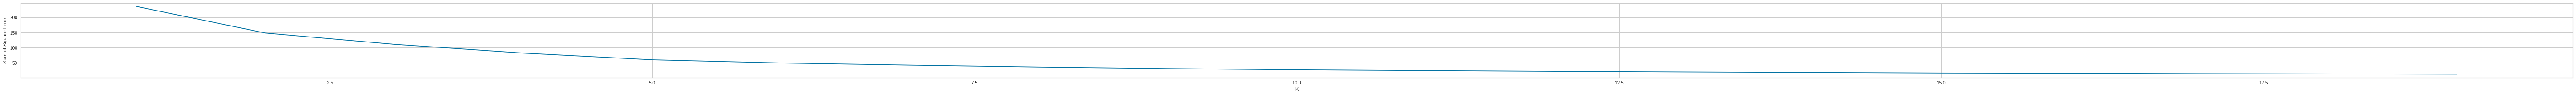

In [ ]:
sse =[]
for k in range(1, 20):
  kmeans = KMeans(n_clusters=k, random_state=0).fit(df_teste.iloc[:,1:])
  sse.append(kmeans.inertia_)
plt.xlabel("K")
plt.ylabel("Sum of Square Error")

plt.rcParams["figure.figsize"] = (20,20)
plt.plot(range(1,20), sse)

Podemos perceber que a descida é menos ingrime a cada iteração, e que a partir da sétima, a diferença entre dois núcleos vizinhos não é tão grande. E levando em consideração que não é bom para nossa análise ter um número muito grande de núcleos, pois isso dificultaria a visualização e separação entre apenas 3 categorias, vamos adotar 7 como o numéro de núcleos.